<a href="https://colab.research.google.com/github/hamednasr/tensorflow/blob/main/06_transfer_learning_in_tensorflow_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Food 101 classification model:

In [1]:
 import tensorflow as tf

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-08 09:31:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-08 09:31:45 (79.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import compare_historys, create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir 

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-03-08 09:31:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.195.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   206MB/s    in 9.1s    

2022-03-08 09:31:55 (170 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data('101_food_classes_10_percent.zip')

In [6]:
train_data_10percent = tf.keras.preprocessing.image_dataset_from_directory\
('/content/101_food_classes_10_percent/train',
 label_mode='categorical',
 image_size=(224,224))

Found 7575 files belonging to 101 classes.


In [7]:
test_data = tf.keras.preprocessing.image_dataset_from_directory\
('/content/101_food_classes_10_percent/test',
 label_mode='categorical',
 image_size=(224,224),shuffle=False)

Found 25250 files belonging to 101 classes.


In [8]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_cheese_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gyoza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_carbonara'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_toast'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 im

In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model101_10percent_checkpoint',
                                                save_weights_only=True,
                                                monitor='val_accuracy',
                                                save_best_only=True)

In [10]:
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.RandomFlip('horizontal'),
                    tf.keras.layers.RandomRotation(0.2),
                    tf.keras.layers.RandomZoom(0.2),
                    tf.keras.layers.RandomHeight(0.2),
                    tf.keras.layers.RandomWidth(0.2)], 
                    name ="data_augmentation")

## feature extractor model:

In [11]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False,pooling='avg')
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

x = data_augmentation(inputs)

x = base_model(x)
print(x.shape)
outputs = tf.keras.layers.Dense(101,activation='softmax',name='output_layer')(x)

model_101FE = tf.keras.Model(inputs,outputs,name='model_101FE')

model_101FE.compile(loss = 'categorical_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ['accuracy'])

model_101FE.summary()

16719872/16705208 [==============================] - 0s 0us/step
(None, 1280)
Model: "model_101FE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [17]:
len(model_101FE.trainable_variables)

2

In [36]:
!rm -r '/content/tensorboard'

In [12]:
model_101FEcheck=tf.keras.callbacks.ModelCheckpoint(
                                    '/content/checkpoints/model_101FE.ckpt',
                                    save_weights_only=True,
                                    save_best_only=True,
                                    monitor='val_accuracy')

In [32]:
history_model_101FE=model_101FE.fit(train_data_10percent,
                                     epochs=5,
                                     validation_data=test_data,
                                     validation_steps = int(0.15*len(test_data)),
                                     callbacks=[create_tensorboard_callback(dir_name='tensorboard',experiment_name='model_101FE'),
                                                model_101FEcheck])

Saving TensorBoard log files to: tensorboard/model_101FE/20220308-073535
Epoch 1/5
237/237 [==============================] - 82s 318ms/step - loss: 3.5101 - accuracy: 0.2462 - val_loss: 2.6514 - val_accuracy: 0.4108
Epoch 2/5
237/237 [==============================] - 60s 251ms/step - loss: 2.4168 - accuracy: 0.4424 - val_loss: 2.2537 - val_accuracy: 0.4629
Epoch 3/5
237/237 [==============================] - 56s 234ms/step - loss: 2.0524 - accuracy: 0.5100 - val_loss: 2.0408 - val_accuracy: 0.4910
Epoch 4/5
237/237 [==============================] - 52s 217ms/step - loss: 1.8288 - accuracy: 0.5527 - val_loss: 1.9500 - val_accuracy: 0.5048
Epoch 5/5
237/237 [==============================] - 48s 200ms/step - loss: 1.6911 - accuracy: 0.5842 - val_loss: 1.9282 - val_accuracy: 0.5034


In [33]:
model_101FE.evaluate(test_data)

790/790 [==============================] - 55s 70ms/step - loss: 1.7195 - accuracy: 0.5541


[1.719482421875, 0.5540593862533569]

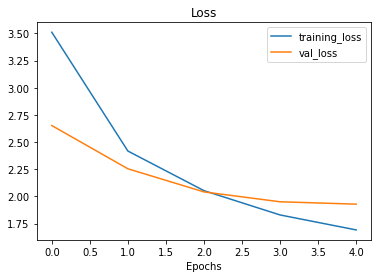

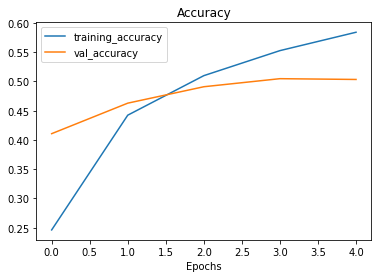

In [34]:
plot_loss_curves(history_model_101FE)

## Fine tuning model:

In [53]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False,pooling='avg')
#base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)
print(x.shape)
outputs = tf.keras.layers.Dense(101,activation='softmax',name='output_layer')(x)

model_101FT = tf.keras.Model(inputs,outputs,name='model_101FT')

model_101FT.compile(loss = 'categorical_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ['accuracy'])

model_101FT.summary()

(None, 1280)
Model: "model_101FT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [54]:
#reload the previous model weights
model_101FT.load_weights('/content/checkpoints/model_101FE.ckpt')

In [55]:
model_101FT.evaluate(test_data)

790/790 [==============================] - 108s 133ms/step - loss: 1.7793 - accuracy: 0.5431


[1.7793233394622803, 0.5430890917778015]

In [56]:
for layer in base_model.layers[:-20]:
  layer.trainable=False

In [57]:
for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_8 False
rescaling_7 False
normalization_7 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [58]:
len(model_101FT.trainable_variables)

20

In [59]:
model_101FT.summary()

Model: "model_101FT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 1,259,157
Non-trainable params: 2,919,795
_________________________________________________________________


In [60]:
model_101FTcheck=tf.keras.callbacks.ModelCheckpoint(
                                    '/content/checkpoints/model_101FT.ckpt',
                                    save_weights_only=True,
                                    save_best_only=True,
                                    monitor='val_accuracy')

In [61]:
model_101FT.compile(loss = 'categorical_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ['accuracy'])

In [62]:
history_model_101FT=model_101FT.fit(train_data_10percent,
                                     epochs=5,
                                     validation_data=test_data,
                                     validation_steps = int(0.15*len(test_data)),
                                     callbacks=[create_tensorboard_callback(dir_name='tensorboard',experiment_name='model_101FT'),
                                                model_101FTcheck])

Saving TensorBoard log files to: tensorboard/model_101FT/20220308-100422
Epoch 1/5
237/237 [==============================] - 88s 336ms/step - loss: 1.7955 - accuracy: 0.5300 - val_loss: 1.9796 - val_accuracy: 0.4979
Epoch 2/5
237/237 [==============================] - 77s 323ms/step - loss: 1.2594 - accuracy: 0.6578 - val_loss: 1.9101 - val_accuracy: 0.5124
Epoch 3/5
237/237 [==============================] - 75s 313ms/step - loss: 0.9225 - accuracy: 0.7335 - val_loss: 2.0524 - val_accuracy: 0.5016
Epoch 4/5
237/237 [==============================] - 68s 282ms/step - loss: 0.7106 - accuracy: 0.7896 - val_loss: 2.4013 - val_accuracy: 0.4290
Epoch 5/5
237/237 [==============================] - 66s 277ms/step - loss: 0.5325 - accuracy: 0.8387 - val_loss: 2.3363 - val_accuracy: 0.4876


In [63]:
model_101FT.evaluate(test_data)

790/790 [==============================] - 105s 133ms/step - loss: 2.0765 - accuracy: 0.5332


[2.0765175819396973, 0.5332277417182922]

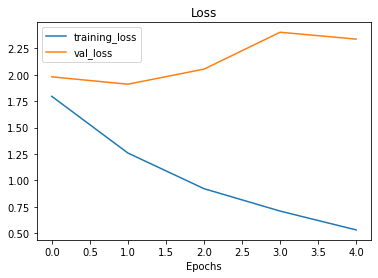

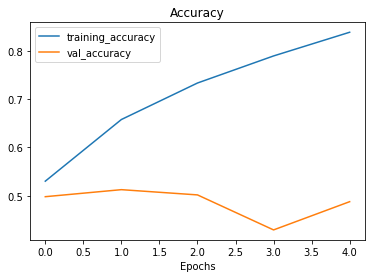

In [64]:
plot_loss_curves(history_model_101FT)